In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pltlab

import numpy as np
import scipy 
import pickle
import pandas as pd
import scipy.stats
from pathlib import Path
import os
from tqdm import tqdm

%matplotlib inline

# plt.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set(color_codes=True)


In [46]:
AGENT_LIST = ["rs-PI", "adv-rs-PI", "s-opt", "h-opt", ]

# Prepare coefficients list
LAMBDA_R_vals = [1.0, 0.0]
LAMBDA_C_vals = [1.0, 0.0]
LAMBDA_COEFFS = [(lr, lc) for lc in LAMBDA_C_vals for lr in LAMBDA_R_vals]

## Hyper-params for plotting

In [4]:
SEED = 0
ENV_NAME = 'large_grid-200' 

# base for all the logs 
BASE_PATH = "/enter/path/here"

# load path for a particular experiment
LOAD_PATH = f"{BASE_PATH}/runagent/{ENV_NAME}/s_{SEED}"

## Load the DF

In [6]:
results_df = pd.read_csv(filepath_or_buffer=f"{LOAD_PATH}/results.csv")

results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     976 non-null    int64  
 1   seed                           976 non-null    int64  
 2   gamma                          976 non-null    float64
 3   cost_limit                     976 non-null    float64
 4   nb_states                      976 non-null    int64  
 5   nb_actions                     976 non-null    int64  
 6   nb_trajectories                976 non-null    int64  
 7   ratio                          976 non-null    float64
 8   pib_R_true_performance         976 non-null    float64
 9   pib_C_true_performance         976 non-null    float64
 10  pib_R_est_performance          976 non-null    float64
 11  pib_C_est_performance          976 non-null    float64
 12  piSolution_R_true_performance  976 non-null    flo

In [12]:
results_df.ratio.unique()

array([0.1, 0.4, 0.7, 0.9])

In [13]:
results_df.nb_trajectories.unique()

array([  10,   50,  500, 2000])

In [15]:
results_df.shape

(976, 23)

In [53]:
results_df.delta_hcpi.unique()

array([nan, 0.1])

## Get parameter list from df

In [16]:
# Dataset generation hyper-parameters
NB_TRAJ_LIST = results_df.nb_trajectories.unique()
RATIO_LIST  = results_df.ratio.unique()

## Util functions

In [17]:
def coeff_to_str(lr = 1.0, lc = 1.0):
    """
    converts the coeffs to string formatting required by pandas 
    """
#     return f'{lr:.1f}_{lc:.1f}'
    return f'{float(lr)}_{float(lc)}'

# coeff_to_str(0,0)

In [19]:
def normalize_returns(df, low=0.0, high=1.0):
    """
    does the following for both R and C:
        - centers the data around baseline performance (by subtracting pi_b)
        - normalize the centered values of the solution in [low, high] range
    """
    
    # copy to work on a duplicate and don't modify orginal
    normalized_df = df.copy()
        
    # center around baseline first 
#     unnormalized_df['piSolution_R_true_performance'] = df['piSolution_R_true_performance'] - df['pib_R_true_performance'] 
#     unnormalized_df['pib_R_true_performance'] = df['pib_R_true_performance'] - df['pib_R_true_performance'] 

    # do normalizaation for R  
    r_min, r_max = df['piSolution_R_true_performance'].min(), df['piSolution_R_true_performance'].max()
    normalized_df['piSolution_R_true_performance'] = (df['piSolution_R_true_performance'] - r_min) / (r_max - r_min) * (high - low) + low
    normalized_df['pib_R_true_performance'] = (df['pib_R_true_performance'] - r_min) / (r_max - r_min) * (high - low) + low
    
    # do normalizaation for C
    c_min, c_max = df['piSolution_C_true_performance'].min(), df['piSolution_C_true_performance'].max()
    normalized_df['piSolution_C_true_performance'] = (df['piSolution_C_true_performance'] - c_min) / (c_max - c_min) * (high - low) + low
    normalized_df['pib_C_true_performance'] = (df['pib_C_true_performance'] - c_min) / (c_max - c_min) * (high - low) + low

    # all the true returns are now normalized in this new df    
    return normalized_df
    

In [20]:
def select_agent_df(df, agent_name):
    """
    filters the df based on the agent type
    """
    if agent_name == 'reg-PI':
        agent_df = df[df['agent_name'] == 'Unconstrained_PI']
    elif agent_name == 'rs-PI':
        agent_df = df[df['agent_name'] == 'Reshaped_PI']
    elif agent_name == 'adv-rs-PI':
        agent_df = df[df['agent_name'] == 'Reshaping_Adv_PI']
    elif agent_name == 's-opt':
        agent_df = df[df.agent_name.str.contains('S_OPT')]
    elif agent_name == 'h-opt':
        agent_df = df[df.agent_name.str.contains('H_OPT')]
    else: 
        raise Exception('unkown agent')
        
    return agent_df

In [21]:
def search_best_perf_params(df, agent, print_=False):
    """
    searches the best run params for a specif agent type for max performance
    """
    params = {}
    
    best_r_val = -np.inf
    best_c_val = +np.inf

    
    # sopt specific params 
    best_delta = None 
    best_eps = None
    best_lb = None 
    best_IS = None 
    
       
    # first pass 
    # iterate over this df and find best R
        
    for index, row in df.iterrows():
        r_val = row['piSolution_R_true_performance']
        c_val = row['piSolution_C_true_performance']
        
        #add to candidates based on R
        if r_val > best_r_val:
            best_r_val = r_val

    
    # in the second pass select C based on the best R
    for index, row in df.iterrows():
        r_val = row['piSolution_R_true_performance']
        c_val = row['piSolution_C_true_performance']
        
        if r_val == best_r_val:
            # select the smallest C
            if c_val < best_c_val:
                best_c_val = c_val
                # keep track of agent specific paramms 
                if agent == 's-opt':
                    best_delta = row['delta']
                    best_eps = row['epsilon']
                elif agent == 'h-opt':
                    best_delta = row['delta_hcpi']
                    best_lb = row['lower_bound_strategy']
                    best_IS = row['IS_estimator']
                else:
                    raise Exception
                    
        
    # store the best values 
    params = {'R' : best_r_val, 
              'C' : best_c_val,}
    
    if agent == 's-opt':
        params['delta'] = best_delta
        params['epsilon'] = best_eps
    elif agent == 'h-opt':
        params['delta'] = best_delta
        params['IS'] = best_IS
        params['lb'] =  best_lb                  
    else:
        raise Exception("haven't implement yet")
    
    if print_:
        print(f"Best params for {agent} are:")
        if agent == 's-opt':
            print(f"\t\t delta:{best_delta}\t epsilon:{best_eps}")
        else:
            print(f"\t\t delta:{best_delta}\t IS:{best_IS}\t lb:{best_lb}")
    
    return params
    

In [22]:
def get_agent_performance(df, agent, print_=False):
    """
    df: filtered df for that Agent and (rho, lambda, D) combination
    agent: agent type
    
    returns: is_safe, imporvement (l2), params 
                params also contain R_best, C_best
    """
    params_dict = {}
    params_dict['name'] = agent
    
    # check if the agent has any safe runs or not 
    # get all runs where solution perfroms better than baseline in both R and C 
    safe_df = df[(df['piSolution_R_true_performance'] >= df['pib_R_true_performance']) & \
                 (df['piSolution_C_true_performance'] <= df['pib_C_true_performance']) ] 

    # check if the shape is 0 or not 
    is_safe = (safe_df.shape[0] > 0)
    params_dict['safe'] = is_safe
    
    improvement = None
    
    if agent in ['s-opt','h-opt']:
        if is_safe:
            # only find the best in the safe solutions
            params_dict = search_best_perf_params(safe_df, agent, print_)
        else:
            # no safe is present, find the best in the worst
            params_dict = search_best_perf_params(df, agent, print_)
    elif agent in ["reg-PI", "rs-PI", "adv-rs-PI"]:
        # no params to search for these agents, the df should only have one row
        assert df.shape[0] == 1
        
        sol_R = df['piSolution_R_true_performance'].values[0]
        sol_C = df['piSolution_C_true_performance'].values[0]
        
        # add that to the param dict
        params_dict['R'] = sol_R
        params_dict['C'] = sol_C
    else:
        raise Exception("unkown agent")
    
    # get the sol val from the best run
    pi_sol_val = np.array([params_dict['R'], params_dict['C']])
    
    # get improvement in L2 from the param dict 
    pi_baseline_r_val = df.pib_R_true_performance.unique()[0]
    pi_baseline_c_val = df.pib_C_true_performance.unique()[0]
    pi_baseline_val = np.array([pi_baseline_r_val, pi_baseline_c_val])

    improvement = np.linalg.norm(pi_sol_val - pi_baseline_val)
    
    if print_:
        print(f"{agent} states: Safe:{is_safe}\t Imp:{improvement:0.4f} R:{params_dict['R']:0.4f}\t C:{params_dict['C']:0.4f} ")
    
    return params_dict, is_safe, improvement
    

## Matplot lib utils

In [23]:
MARKER_DICT = { "s-opt" : '*', 
               "h-opt" : 's', 
               "reg-PI" : '>', #
               "rs-PI" : '<', #
               "adv-rs-PI": 'v', #d
              }

# marler info can be found https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers 
# use 'o', 'd', 'D'

MARKER_SIZE = 12

MARKER_OPACITY = 0.75

In [24]:
AGENT_LABEL_DICT = { "s-opt" : 'S-OPT', 
                    "h-opt" : 'H-OPT', 
                    "reg-PI" : 'Unconstrained', 
                    "rs-PI" : 'Linearized', 
                    "adv-rs-PI": 'Adv-Linearized', #d
                   }

In [25]:
def create_custom_colormap(tags, scheme='viridis', top_k=0.8):
    """
    tags: associated with each bin (unique list)
    
    creates a custom color map that works for discrete ints
    
    source: https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    """
    bins = len(tags)+1
#     cmap = pltlab.cm.jet
    if scheme == 'dark':
        cmap = pltlab.cm.Dark2
    elif scheme == 'viridis':
        cmap = pltlab.cm.viridis
    elif scheme == 'plasma':
        cmap = pltlab.cm.plasma
    else:
        raise Exception('unk color scheme')
    
    # extract all colors from the default map
    cmaplist = [cmap(i) for i in range(int(top_k * cmap.N))]
        
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    # define the bins and normalize
    bounds = np.linspace(0, bins-1, bins)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    return cmap, norm, bounds    

## Plot the entire plot for this enviornment and run

In [34]:
def ax_plot_lambda_rho_combo(ax, df, lR, lC, ratio, plot='scatter', normalize=True, print_=False):
    """
    same as the above function, but doesn't plot the legend or the colorbar 

    returns the cmap objects instead 
    """
    # create the lambda string
    coeff_str =  coeff_to_str(lR, lC)
    # get filter/index the dataframe 
    condition =  df.ratio.eq(ratio) & df.coeff.eq(coeff_str)
    filtered_df = df[condition]

    # can't be empty
    assert filtered_df.shape[0] > 0
    
    # Get the unconstrainted agent too
    # it is independent of reward weighing but depends on ratio here 
    unconst_df = df[(df['agent_name'] == 'Unconstrained_PI')  & (df['ratio']==ratio)]
    
    # add it to the filtered_df
    trajs_and_agents_df = pd.concat([filtered_df, unconst_df]).copy()
    
    if normalize:
        # the results for all the plots will be normalized using the same scaling
        trajs_and_agents_df = normalize_returns(trajs_and_agents_df, low=0.0, high=1.0)
    
    # get the baseline performance for this condition
    assert trajs_and_agents_df.pib_R_true_performance.unique().shape[0] == 1
    assert trajs_and_agents_df.pib_C_true_performance.unique().shape[0] == 1
    
    pib_R_true_performance = trajs_and_agents_df.pib_R_true_performance.unique()[0]
    pib_C_true_performance = trajs_and_agents_df.pib_C_true_performance.unique()[0]
    
    baseline_results = {'name': 'baseline', 
                        'R' : pib_R_true_performance,  
                        'C' : pib_C_true_performance, }
    
    # TODO: make a plot function??
    if plot=='scatter':        
        # plot the baseline stats
        ax.axhline(y= baseline_results['R'], label = "$J_{R}(\pi_{b} , M^{\star})$", linestyle=":", lw=4)
        ax.axvline(x= baseline_results['C'], label = "$J_{C}(\pi_{b} , M^{\star})$", linestyle = "-.", c='r', lw=2)
    
        # create the custom map for scatter for nb_traj 
        cmap, norm, bounds = create_custom_colormap(list(NB_TRAJ_LIST))
        

    # go over all the trajectories 
    for traj_idx, nb_traj in enumerate(NB_TRAJ_LIST):
        
        # filter based on traj here
        all_agents_df = trajs_and_agents_df[(trajs_and_agents_df['nb_trajectories']==nb_traj)]
        
        # now plot for each agent 
        for agent_name in AGENT_LIST:
            # filter the agent 
            agent_df = select_agent_df(all_agents_df, agent_name)
            # get the results 
            agent_results, agent_safe, agent_improvement =  get_agent_performance(agent_df, agent_name, print_)
        
            # plot here
            if plot=='scatter':
                ax.scatter(agent_results['C'], agent_results['R'], 
                           marker=MARKER_DICT[agent_name], 
                           s=(MARKER_SIZE-3 + 2*traj_idx)**2, #size changes with inc in dataset
#                            s=(MARKER_SIZE-2)**2, #default size 
                           label= AGENT_LABEL_DICT[agent_name],
                           alpha = MARKER_OPACITY,
                           c=traj_idx,
                           cmap=cmap, norm=norm)
                 
            

    return cmap, bounds, norm

In [35]:
nr_rows = len(LAMBDA_COEFFS)
nr_cols = len(RATIO_LIST)

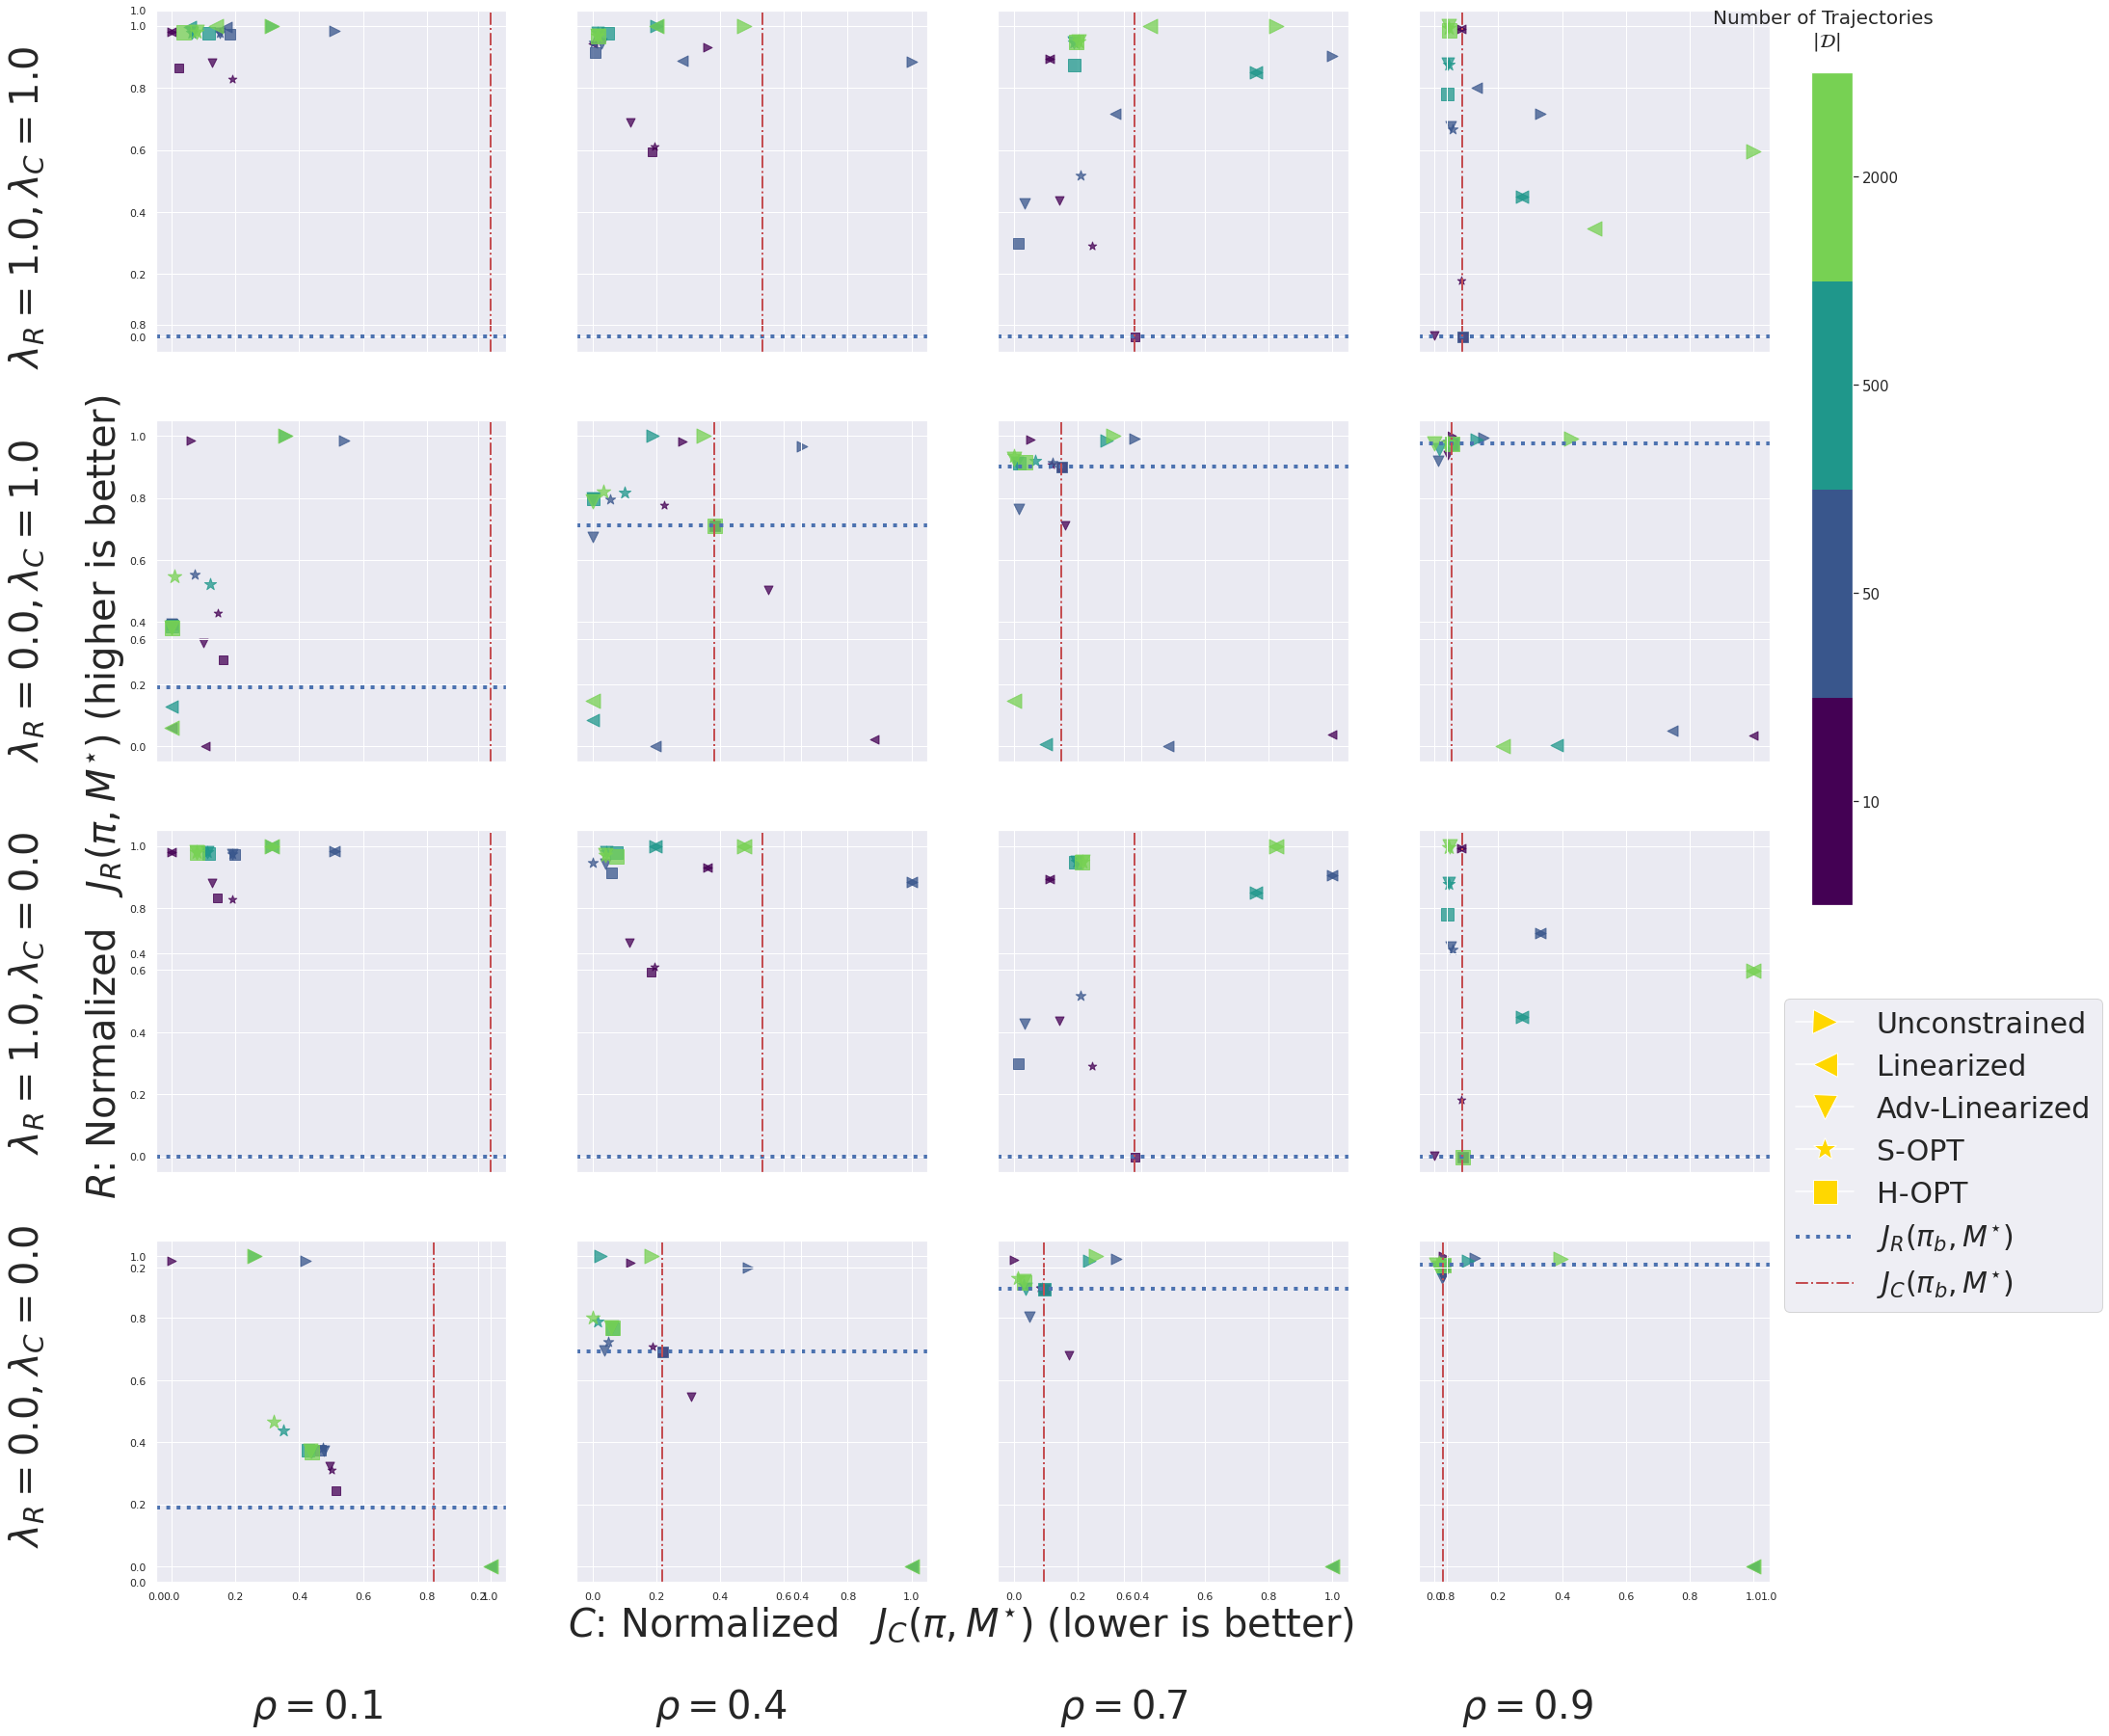

In [36]:
FIG_LEN = 30 # 36

fig, axes = plt.subplots(nr_rows, nr_cols, figsize=(FIG_LEN,FIG_LEN), sharex=True, sharey=True)


for row, coeff in enumerate(LAMBDA_COEFFS):
    
    for col, ratio in enumerate(RATIO_LIST):
        
        # select the curren axes 
        ax = axes[row, col]
                
        # plot 
        cmap, bounds, norm = ax_plot_lambda_rho_combo(ax, results_df, coeff[0], coeff[1], ratio, plot='scatter', normalize=True, print_=False)
        

        
# add the common x and y labels
fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("$C$: Normalized   $J_{{C}}(\pi, M^{{\star}})$ (lower is better) ", fontsize=40)
plt.ylabel("$R$: Normalized   $J_{{R}}(\pi, M^{{\star}})$ (higher is better)", fontsize=40)


# define the rows and columns
xranges = [f"$\\rho={i}$" for i in RATIO_LIST]
yranges = [f"$\\lambda_{{R}}={i[0]},\\lambda_{{C}}={i[1]}$" for i in LAMBDA_COEFFS]

for pos, text in enumerate(xranges):
    plt.text(pos * (1/nr_cols) + 0.4*(1/nr_cols), -0.08, text, fontsize=40, ha='center', va='center')

# this place bottom to top, whereas rows are generated top to bottom    
for pos, text in enumerate(yranges[::-1]):
    plt.text(-0.08, pos* (1/nr_rows) + 0.5*(1/nr_rows), text, fontsize=40, ha='center', va='center', rotation='vertical')


    
# add the colorbar now 
# remove the last tick and shift them half a step down
new_bounds = bounds[:-1]
new_bounds = new_bounds + 0.5
        
# # ticker custom tags
fmt = mpl.ticker.FuncFormatter(lambda x, pos: NB_TRAJ_LIST[int(x)])

# # create a second axes for the colorbar
# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
ax2 = fig.add_axes([0.92, 0.45, 0.02, 0.4])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=new_bounds, boundaries=bounds, format=fmt)
cb.ax.tick_params(labelsize=15)
plt.text(1.2, 4.2, 'Number of Trajectories\n $|\mathcal{D}|$', fontsize=20, ha='center', va='center')

# ax2.set_ylabel('Number of Trajectories $|\mathcal{D}|$', size=15)

# alternatively, we can use this for colorbar
# cbar = fig.colorbar(ax.get_children()[0], ax=fig.get_axes(), shrink=0.98, 
#                         ticks=[1,2,3,4])


# add the legend here manually
import matplotlib.lines as mlines

legend_elements = []
for agent in AGENT_LIST:
    legend_elements.append(mlines.Line2D([0], [0], marker=MARKER_DICT[agent], color='w', label=AGENT_LABEL_DICT[agent],
                          markerfacecolor='gold', markersize=25) )

    
# add legend elements for the baselines
legend_elements.append(mlines.Line2D([0], [0], color='b',  linestyle=":", label="$J_{R}(\pi_{b} , M^{\star})$", lw=4) )
legend_elements.append(mlines.Line2D([0], [0], color='r',  linestyle="-.", label="$J_{C}(\pi_{b} , M^{\star})$", lw=2) )


# Create the figure
# cordinates are now wrt to ax2
plt.legend(handles=legend_elements, bbox_to_anchor=(-1.0, -0.3), loc='center left', prop={'size':30})

# fig.tight_layout()
plt.show()

## Find and save the best params to launch multiple runs

In [37]:
def search_best_linearized_safe_params(df, coeffs, agent, print_=False):
    """
    df: contains (lR,lC,\rho) combination
    
    find the hyper-params for an agent that is most "safe" across all runs, and gives most linearized-improvement
    for across all trajectories
    
    if none of them is safe, pick the one with the least failure rate
    """
    params = {}
    
    best_improvement = -np.inf

    # params that vary for S-opt and H-opt
    best_delta = None 
    best_eps = None
    best_lb = None 
    best_IS = None 
    
    # create a new column for linearized performance?
    
    for index, row in df.iterrows():
        r_val = row['piSolution_R_true_performance']
        c_val = row['piSolution_C_true_performance']
        
        #add to candidates based on R
        if r_val > best_r_val:
            best_r_val = r_val

    
    # in the second pass select C based on the best R
    for index, row in df.iterrows():
        r_val = row['piSolution_R_true_performance']
        c_val = row['piSolution_C_true_performance']
        
        if r_val == best_r_val:
            # select the smallest C
            if c_val < best_c_val:
                best_c_val = c_val
                # keep track of agent specific paramms 
                if agent == 's-opt':
                    best_delta = row['delta']
                    best_eps = row['epsilon']
                elif agent == 'h-opt':
                    best_delta = row['delta_hcpi']
                    best_lb = row['lower_bound_strategy']
                    best_IS = row['IS_estimator']
                else:
                    raise Exception
                    
        
    # store the best values 
    params = {'R' : best_r_val, 
              'C' : best_c_val,}
    
    if agent == 's-opt':
        params['delta'] = best_delta
        params['epsilon'] = best_eps
    elif agent == 'h-opt':
        params['delta'] = best_delta
        params['IS'] = best_IS
        params['lb'] =  best_lb                  
    else:
        raise Exception("haven't implement yet")
    
    if print_:
        print(f"Best params for {agent} are:")
        if agent == 's-opt':
            print(f"\t\t delta:{best_delta}\t epsilon:{best_eps}")
        else:
            print(f"\t\t delta:{best_delta}\t IS:{best_IS}\t lb:{best_lb}")
    
    return params
    

In [38]:
def get_agent_params_across_dataset_size(df, agent, print_=False):
    """
    df: filtered df for that Agent and (rho, lambda) combination
    agent: agent type
    
    returns: params 
    """
    params_dict = {}
    params_dict['name'] = agent
    
    if agent in ["reg-PI", "rs-PI", "adv-rs-PI"]:
        # there are no params to be found
        return params_dict
    
    # else agent is s-opt or h-opt
    if agent == 's-opt':
        
        best_safe_count_eps = 0.0
        
        safe_count_dict = {}

        # for each eps
        possible_eps = df.epsilon.unique()
        possible_eps = possible_eps[~np.isnan(possible_eps)] #remove nan
        possible_eps = possible_eps[possible_eps<np.inf] #remove inf
        
        for eps in possible_eps:
            
            # check how safe it is
            eps_df = df[df['epsilon'] == eps]
            safe_count = 0
            
            for index, row in eps_df.iterrows():
                is_safe = (row['piSolution_R_true_performance'] >= row['pib_R_true_performance']) and\
                         (row['piSolution_C_true_performance'] <= row['pib_C_true_performance'])
                
                if is_safe:
                    safe_count += 1
            
            # done with all rows in this eps-df
            # store so that we don't have to calculate them again
            safe_count_dict[eps] = safe_count 
            
            if safe_count >= best_safe_count_eps:
                # if two eps are equally safe, pick the later one
                # a bit aggressive in our strateget
                best_safe_count_eps = safe_count
                params_dict['eps'] = eps
                
 
    elif agent == 'h-opt':        
        # possible combinations
        # for delta_hcpi
        possible_delta =  df.delta_hcpi.unique()
        possible_delta = possible_delta[~np.isnan(possible_delta)]
        
        # for IS_estimator
        possible_IS = df.IS_estimator.unique()
        possible_IS = [x for x in possible_IS if str(x) != 'nan']
        
        # possible lb
#         possible_lb = df.lower_bound_strategy.unique()
#         possible_lb = [x for x in possible_lb if str(x) != 'nan']
        possible_lb = ['student_t_test']

        # max safety factor
        best_safe_count = 0.0
        
        for delta in possible_delta: 
            for is_est in possible_IS:
                for lbs in possible_lb:
                    hcpi_df = df[(df['delta_hcpi'] == delta) & (df['IS_estimator'] == is_est) & (df['lower_bound_strategy'] == lbs)]

                    safe_count = 0
            
                    for index, row in hcpi_df.iterrows():
                        is_safe = (row['piSolution_R_true_performance'] >= row['pib_R_true_performance']) and\
                                        (row['piSolution_C_true_performance'] <= row['pib_C_true_performance'])

                        if is_safe:
                            safe_count += 1
            
                    # done with all rows in this combination
                    if safe_count >= best_safe_count:
                        best_safe_count = safe_count
                        params_dict['delta'] = delta
                        params_dict['IS'] = is_est
                        params_dict['lb'] =  lbs      
        
    else:
        raise Exception("unk agent")
    

    if print_:
        print(f"Best params for {agent} are:")
        if agent == 's-opt':
            print(f"\t\t epsilon:{params_dict['eps']}")
        else:
            print(f"\t\t delta:{params_dict['delta']}\t IS:{params_dict['IS']}\t lb:{params_dict['lb']}")
    
    return params_dict

In [39]:
def get_params_results(df, agent_params):
    """
    get the results for the specified params 
    
    agent_df = df filtered on \rho, \lambda, agent-name, and nb_traj
    """
    # get the agent type
    agent = agent_params['name']
    
    results_dict = {}
    
    if agent in ["reg-PI", "rs-PI", "adv-rs-PI"]:
        # no need of filter
        pass
    elif agent == 's-opt':
        # filter on eps
        df = df[df['epsilon'] == agent_params['eps']]
    elif agent == 'h-opt':
        # filter on delta, is, lb
        df = df[(df['delta_hcpi'] == agent_params['delta']) & (df['IS_estimator'] == agent_params['IS']) & (df['lower_bound_strategy'] == agent_params['lb'])]
    else:
        raise Exception("unkown agent")
        
    
    # df should only have one row at this point
    assert df.shape[0] == 1
    
    # no params asssociated with these agents        
    sol_R = df['piSolution_R_true_performance'].values[0]
    sol_C = df['piSolution_C_true_performance'].values[0]
    sol_L = df['piSolution_linearized_return'].values[0]

    # add to the results dict
    results_dict['R'] = sol_R
    results_dict['C'] = sol_C
    results_dict['L'] = sol_L
    
    # check if safe or not 
    safe_df = df[(df['piSolution_R_true_performance'] >= df['pib_R_true_performance']) & \
                 (df['piSolution_C_true_performance'] <= df['pib_C_true_performance']) ] 
    
    # check if the shape is 0 or not 
    is_safe = (safe_df.shape[0] > 0)
    
    results_dict['is_safe'] = is_safe
    
    return results_dict
    
    

In [40]:
def get_agent_params_across_rho_and_dataset_size(df, agent, print_=False):
    """
    df: filtered df for that Agent and (rho, lambda, D) combination
    agent: agent type
    
    returns: failure, imporvement (l2), params 
                params also contain R_best, C_best
    """
    pass
   
    

In [41]:
def add_linearized_return(df, coeff):
    """
    does the following for both R and C:
        - centers the data around baseline performance (by subtracting pi_b)
        - normalize the centered values of the solution in [low, high] range
    """
    
    # copy to work on a duplicate and don't modify orginal
    normalized_df = df.copy()
        
    # do normalizaation for policies
    normalized_df['piSolution_linearized_return'] = (coeff[0] * df['piSolution_R_true_performance']) - (coeff[1] * df['piSolution_C_true_performance'])

    # for the baseline
    normalized_df['pib_linearized_return'] = (coeff[0] * df['pib_R_true_performance']) - (coeff[1] * df['pib_C_true_performance'])
    
    return normalized_df

In [42]:
def safety_based_lambda_and_rho_plot(ax, df, lR, lC, ratio, plot='scatter', normalize=False, print_=False):
    """
    same as the above function, but doesn't plot the legend or the colorbar 

    returns the cmap objects instead 
    """
    # create the lambda string
    coeff_str =  coeff_to_str(lR, lC)
    # get filter/index the dataframe 
    condition =  df.ratio.eq(ratio) & df.coeff.eq(coeff_str)
    filtered_df = df[condition]

    # can't be empty
    assert filtered_df.shape[0] > 0
    
    # Get the unconstrainted agent too
    # it is independent of reward weighing but depends on ratio here 
    unconst_df = df[(df['agent_name'] == 'Unconstrained_PI')  & (df['ratio']==ratio)]
    
    # add it to the filtered_df
    trajs_and_agents_df = pd.concat([filtered_df, unconst_df]).copy()
    
    # add a new column for the linearized_performance (this is always unnormalized)
    trajs_and_agents_df = add_linearized_return(trajs_and_agents_df, (lR, lC))
    
    if normalize:
        # the results for all the plots will be normalized using the same scaling
        trajs_and_agents_df = normalize_returns(trajs_and_agents_df, low=0.0, high=1.0)
    
    
        
    # get the baseline performance for this condition
    assert trajs_and_agents_df.pib_R_true_performance.unique().shape[0] == 1
    assert trajs_and_agents_df.pib_C_true_performance.unique().shape[0] == 1
    assert trajs_and_agents_df.pib_linearized_return.unique().shape[0] == 1
    
    pib_R_true_performance = trajs_and_agents_df.pib_R_true_performance.unique()[0] # rmove later 
    pib_C_true_performance = trajs_and_agents_df.pib_C_true_performance.unique()[0]
    pib_L_true_performance = trajs_and_agents_df.pib_linearized_return.unique()[0]
    
    baseline_results = {'name': 'baseline', 
                        'R' : pib_R_true_performance,  
                        'C' : pib_C_true_performance,
                        'L' : pib_L_true_performance
                       }
    
    # TODO: make a plot function??
    if plot=='scatter':        
        # plot the baseline stats
        ax.axhline(y= baseline_results['R'], label = "$J_{R}(\pi_{b} , M^{\star})$", linestyle=":", lw=4)
        ax.axvline(x= baseline_results['C'], label = "$J_{C}(\pi_{b} , M^{\star})$", linestyle = "-.", c='r', lw=2)
    
        # create the custom map for scatter for nb_traj 
        cmap, norm, bounds = create_custom_colormap(list(NB_TRAJ_LIST))
            
        
    # now plot for each agent 
    for agent_name in AGENT_LIST:
        
        # filter the agent 
        agent_df = select_agent_df(trajs_and_agents_df, agent_name)
            
        # get the params 
        agent_params =  get_agent_params_across_dataset_size(agent_df, agent_name, print_)
        
        # SAVE THESE PARAMS eventually
        
        # plots across trajs here 
        for traj_idx, nb_traj in enumerate(NB_TRAJ_LIST):
        
            # filter the result based on nb_traj
            agent_traj_df = agent_df[(agent_df['nb_trajectories']==nb_traj)]
            
            # get the results for those params 
            agent_results = get_params_results(agent_traj_df, agent_params) 
        
            if print_:
                print(f"{agent_name} with {nb_traj}\t L:{agent_results['L']:0.4f}(vs-{baseline_results['L']:0.4f}) \tSafe:{agent_results['is_safe']}")
            
            # plot here
            if plot=='scatter':
                ax.scatter(agent_results['C'], agent_results['R'], 
                           marker=MARKER_DICT[agent_name], 
                           s=(MARKER_SIZE-3 + 2*traj_idx)**2, #size changes with inc in dataset
                           label= AGENT_LABEL_DICT[agent_name],
                           alpha = MARKER_OPACITY,
                           c=traj_idx,
                           cmap=cmap, norm=norm)
                 

    return cmap, bounds, norm

### Plot everything again but with new selection criteria

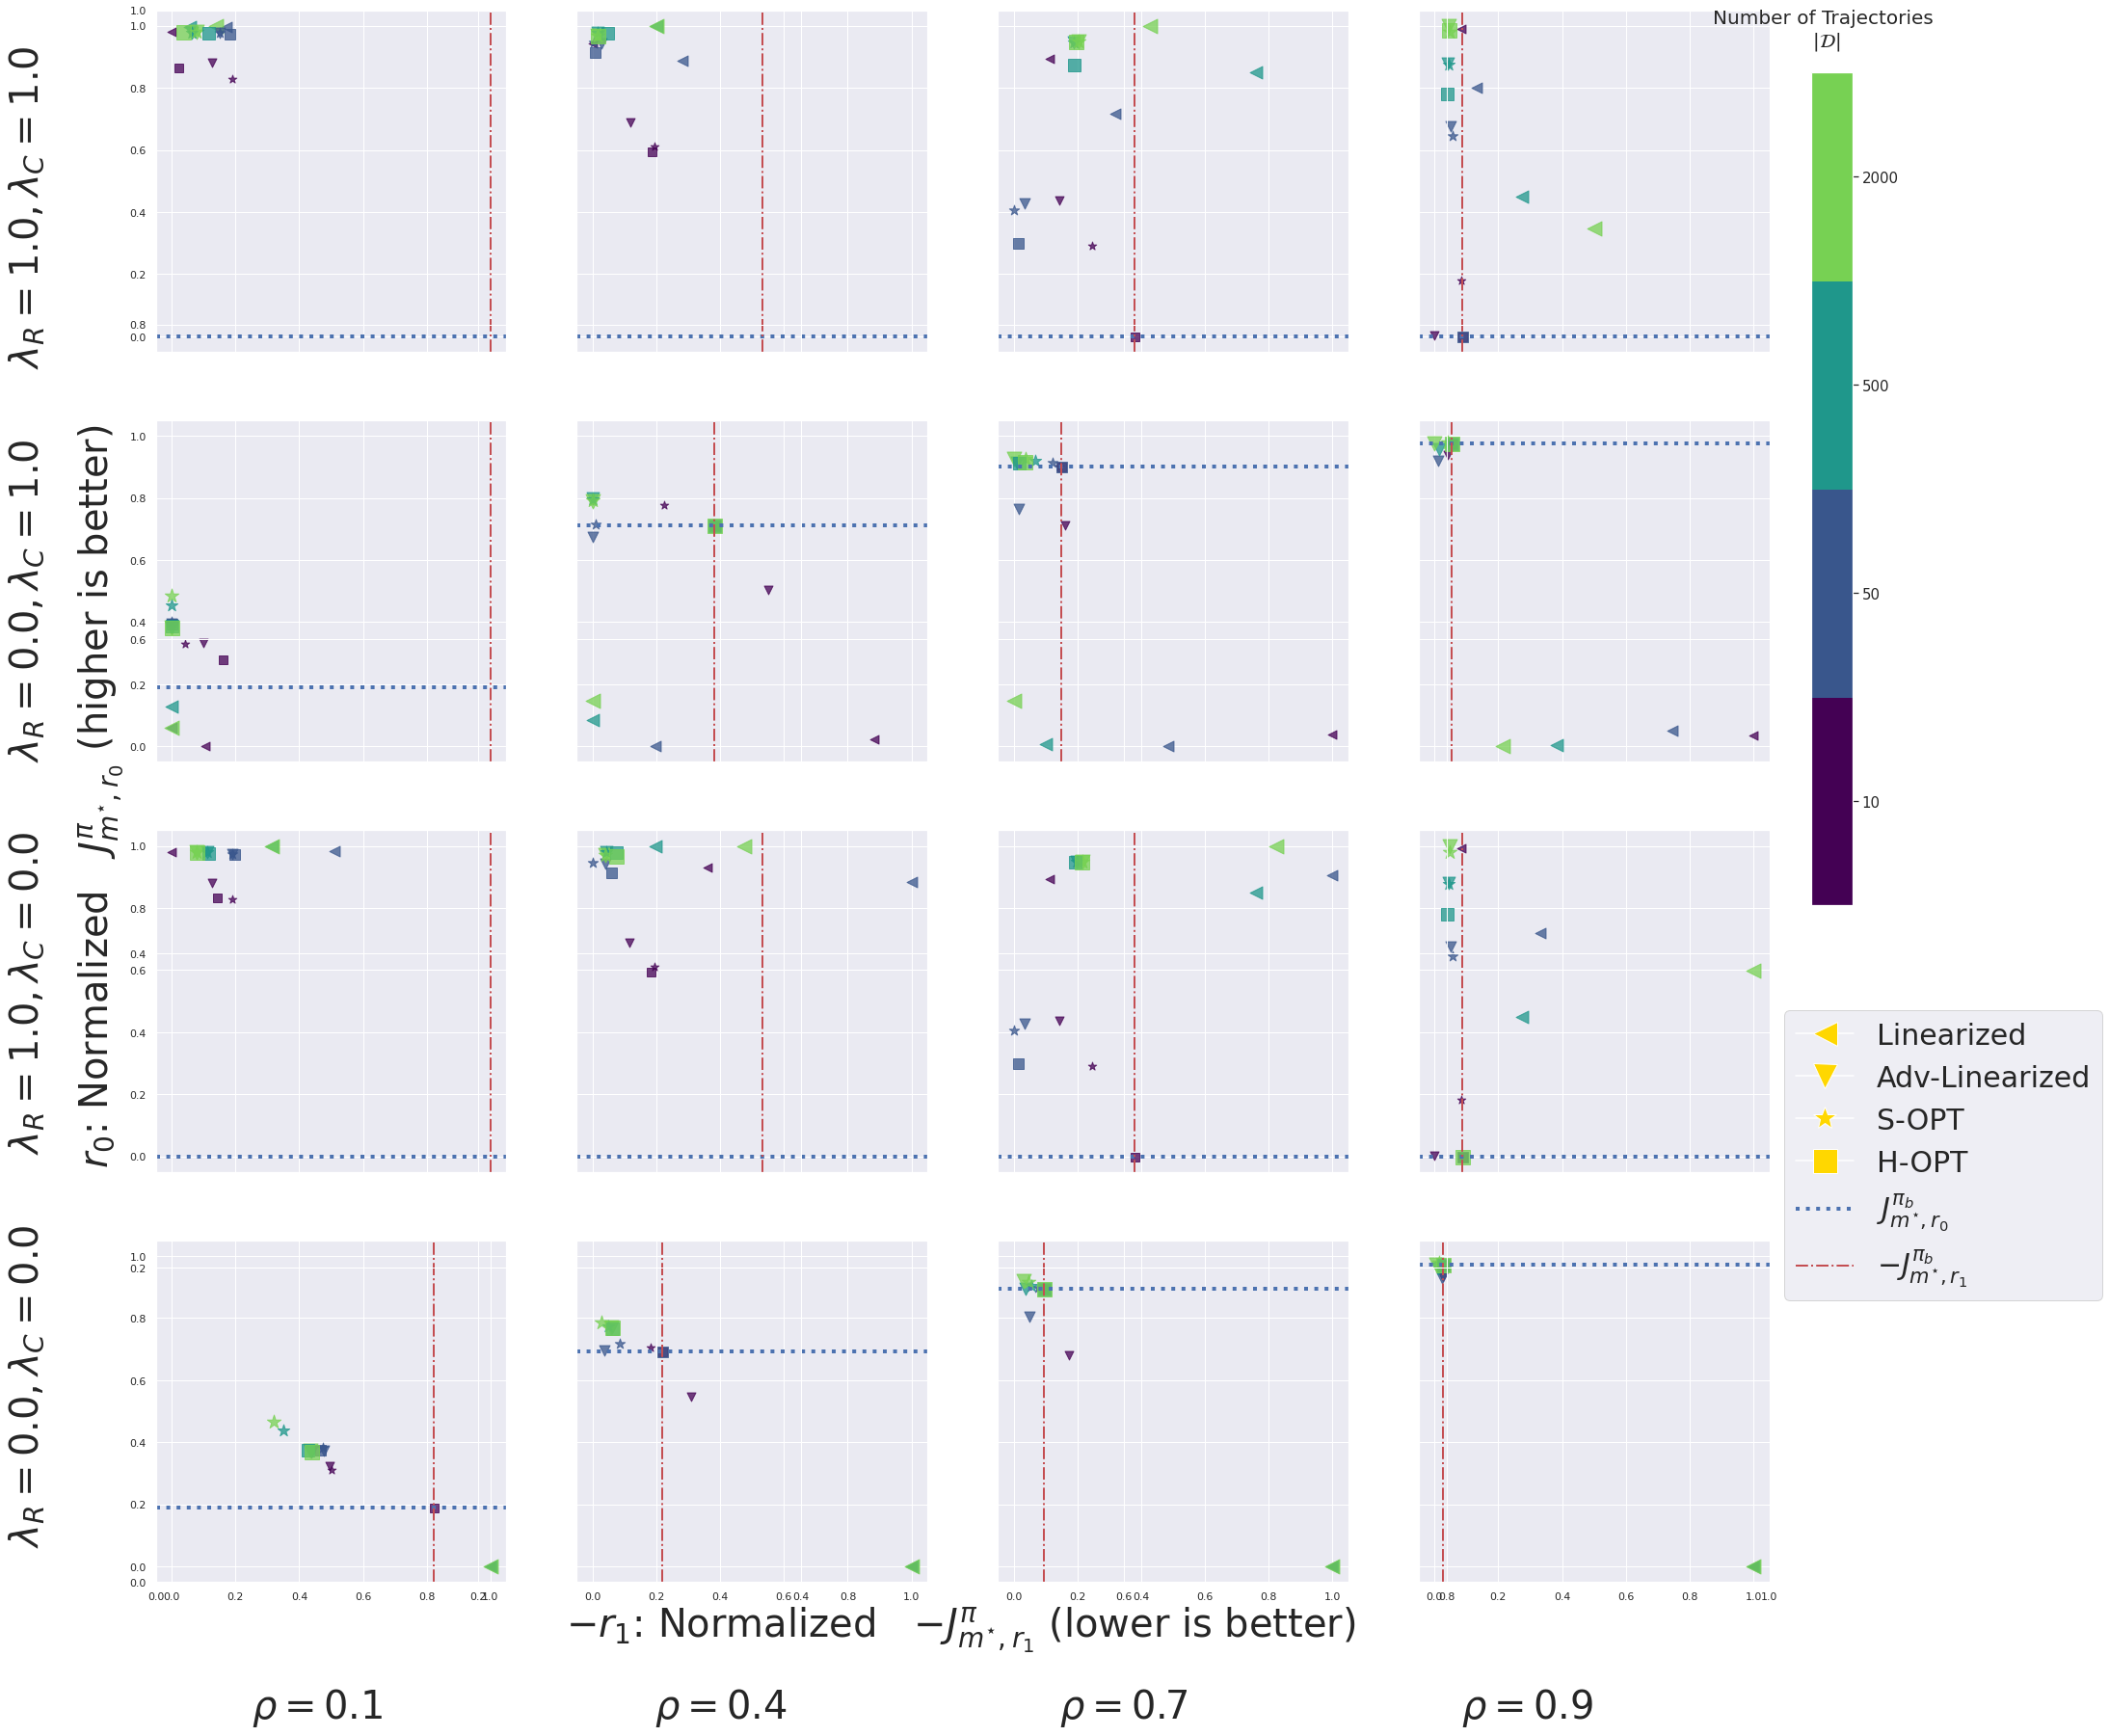

In [48]:

# same as the above 
FIG_LEN = 30 # 36

fig, axes = plt.subplots(nr_rows, nr_cols, figsize=(FIG_LEN,FIG_LEN), sharex=True, sharey=True)


for row, coeff in enumerate(LAMBDA_COEFFS):
    for col, ratio in enumerate(RATIO_LIST):
        # select the curren axes 
        ax = axes[row, col]
        # plot 
        cmap, bounds, norm = safety_based_lambda_and_rho_plot(ax, results_df, coeff[0], coeff[1], ratio, normalize=True, plot='scatter',  print_=False)


# add the common x and y labels
fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("$- r_1$: Normalized   $- J_{{m^{{\star}}, r_1}}^{{\pi}}$ (lower is better) ", fontsize=40)
plt.ylabel("$r_0$: Normalized   $J_{{m^{{\star}}, r_0}}^{{\pi}}$ (higher is better)", fontsize=40)


# define the rows and columns
xranges = [f"$\\rho={i}$" for i in RATIO_LIST]
yranges = [f"$\\lambda_{{R}}={i[0]},\\lambda_{{C}}={i[1]}$" for i in LAMBDA_COEFFS]

for pos, text in enumerate(xranges):
    plt.text(pos * (1/nr_cols) + 0.4*(1/nr_cols), -0.08, text, fontsize=40, ha='center', va='center')

# this place bottom to top, whereas rows are generated top to bottom    
for pos, text in enumerate(yranges[::-1]):
    plt.text(-0.08, pos* (1/nr_rows) + 0.5*(1/nr_rows), text, fontsize=40, ha='center', va='center', rotation='vertical')


    
# add the colorbar now 
# remove the last tick and shift them half a step down
new_bounds = bounds[:-1]
new_bounds = new_bounds + 0.5
        
# # ticker custom tags
fmt = mpl.ticker.FuncFormatter(lambda x, pos: NB_TRAJ_LIST[int(x)])

# # create a second axes for the colorbar
# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
ax2 = fig.add_axes([0.92, 0.45, 0.02, 0.4])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=new_bounds, boundaries=bounds, format=fmt)
cb.ax.tick_params(labelsize=15)
plt.text(1.2, 4.2, 'Number of Trajectories\n $|\mathcal{D}|$', fontsize=20, ha='center', va='center')

# ax2.set_ylabel('Number of Trajectories $|\mathcal{D}|$', size=15)

# alternatively, we can use this for colorbar
# cbar = fig.colorbar(ax.get_children()[0], ax=fig.get_axes(), shrink=0.98, 
#                         ticks=[1,2,3,4])


# add the legend here manually
import matplotlib.lines as mlines

legend_elements = []
for agent in AGENT_LIST:
    legend_elements.append(mlines.Line2D([0], [0], marker=MARKER_DICT[agent], color='w', label=AGENT_LABEL_DICT[agent],
                          markerfacecolor='gold', markersize=25) )

    
# add legend elements for the baselines
legend_elements.append(mlines.Line2D([0], [0], color='b',  linestyle=":", label="$J_{m^{\star}, r_0}^{\pi_{b}}$", lw=4) )
legend_elements.append(mlines.Line2D([0], [0], color='r',  linestyle="-.", label="$- J_{m^{\star}, r_1}^{\pi_{b}}$", lw=2) )


# Create the figure
# cordinates are now wrt to ax2
plt.legend(handles=legend_elements, bbox_to_anchor=(-1.0, -0.3), loc='center left', prop={'size':30})

# fig.tight_layout()
plt.show()

## For saving the params for each kind of agent in a dict

In [ ]:
def save_safety_based_lambda_and_rho_params(df, lambda_coeff_list, ratio_list, save_path="./", print_=False):
    """
    same as the above function, but instead of plotting save the params in a dict to evaluate for multiplie-runs
    """
    results_dict = {}
    
    for coeff in lambda_coeff_list:
        
        #init dict for this lambda combination
        results_dict[coeff] = {}
        
        for ratio in ratio_list:

            # init a dict for this ratio
            results_dict[coeff][ratio] = {}
            
            # do df operations now 
            # create the lambda string
            coeff_str =  coeff_to_str(coeff[0], coeff[1])
            # get filter/index the dataframe 
            condition =  df.ratio.eq(ratio) & df.coeff.eq(coeff_str)
            filtered_df = df[condition]
            # can't be empty
            assert filtered_df.shape[0] > 0
    
            # Get the unconstrainted agent too
            # it is independent of reward weighing but depends on ratio here 
            unconst_df = df[(df['agent_name'] == 'Unconstrained_PI')  & (df['ratio']==ratio)]
            # add it to the filtered_df
            trajs_and_agents_df = pd.concat([filtered_df, unconst_df]).copy()
        
            # now params for each agent 
            for agent_name in AGENT_LIST:
                # filter the agent 
                agent_df = select_agent_df(trajs_and_agents_df, agent_name)
                # get the params 
                agent_params =  get_agent_params_across_dataset_size(agent_df, agent_name, print_)
                # SAVE the params 
                results_dict[coeff][ratio][agent_name] = agent_params
        
    # save the dict as a pickle object
    with open(f'{save_path}/best_params.p', 'wb') as f:
        pickle.dump(results_dict, f)

    return results_dict

In [ ]:
saved_params = save_safety_based_lambda_and_rho_params(results_df, lambda_coeff_list=LAMBDA_COEFFS, ratio_list=RATIO_LIST, save_path="./", print_=True)